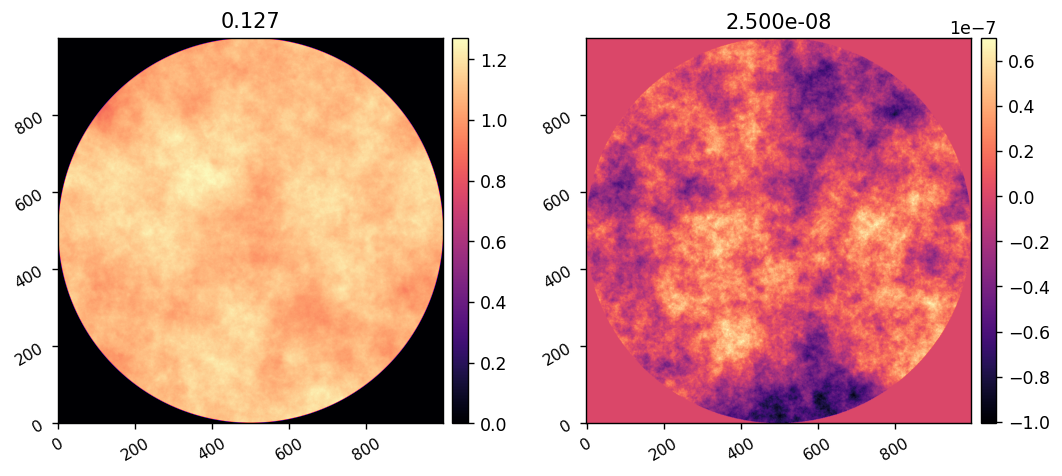

In [1]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])

scc_diam = 150*u.um
scc_position = (15/2.5*u.mm, 0*u.mm)

In [8]:
import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


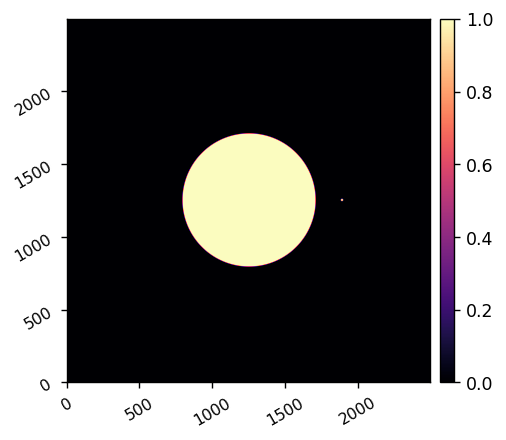

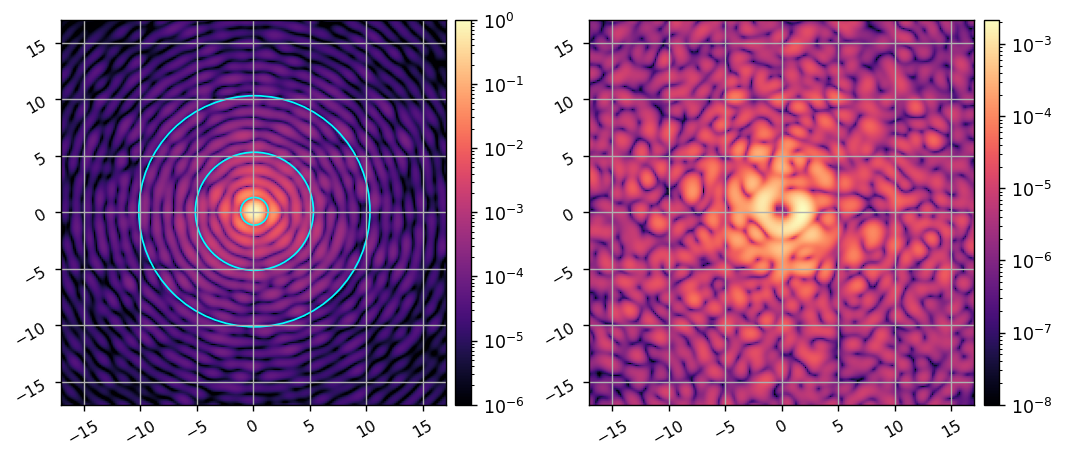

In [9]:
reload(cscoob)
model = cscoob.CORO()
model.scc_diam = scc_diam
model.scc_pinhole_position = scc_position
model.use_scc()

imshow1(model.LYOT)

model.WFE = WFE
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

im = model.snap()

imshow2(ref_psf/model.Imax_ref, im, lognorm=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])


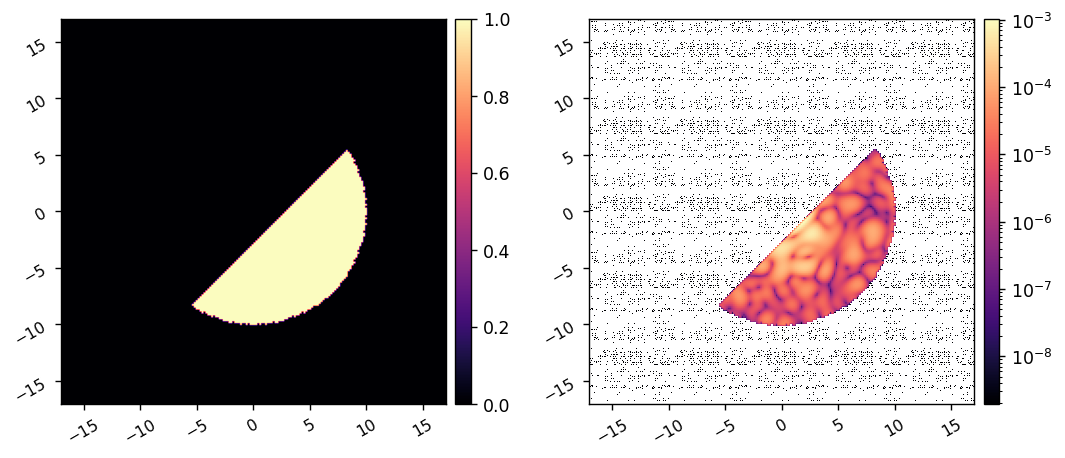

In [4]:
reload(lina.utils)
control_mask = lina.utils.create_annular_focal_plane_mask(model, 2, 10, 2, rotation=45)
imshow2(control_mask, im*control_mask, lognorm2=True, pxscl=model.psf_pixelscale_lamD)



In [5]:
reload(lina.scc)
est_fun = lina.scc.estimate_coherent_mod
est_params = {
    'r_npix':18, 
    'shift':(-1,23), 
    'plot':True,
}

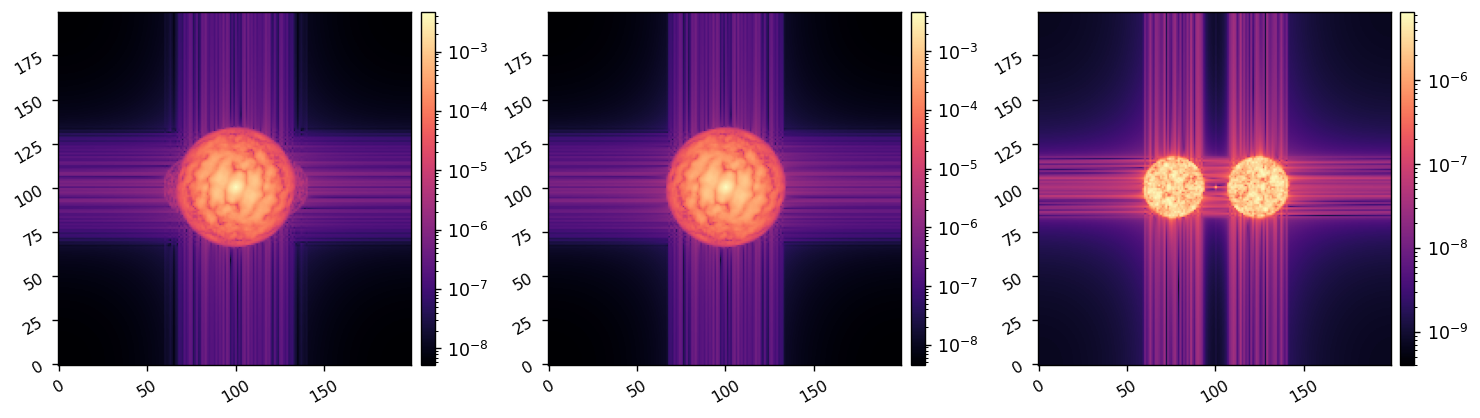

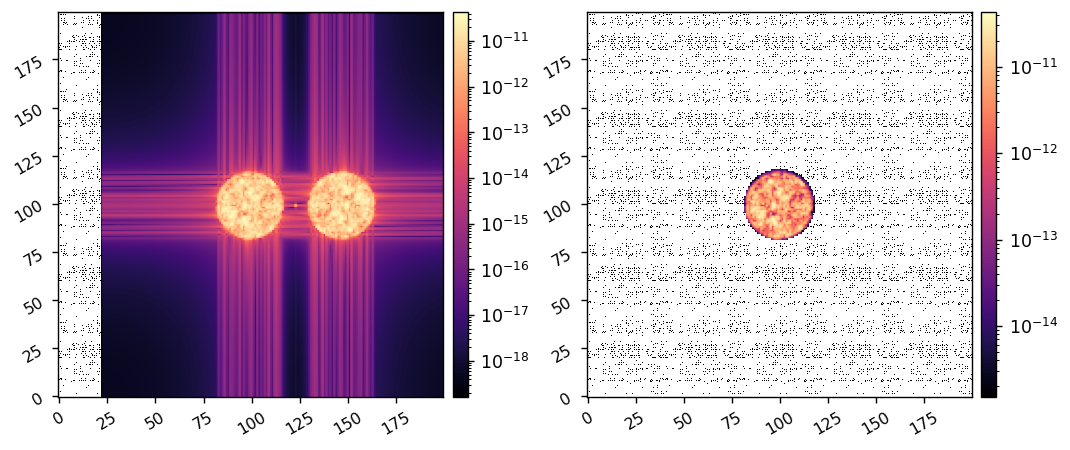

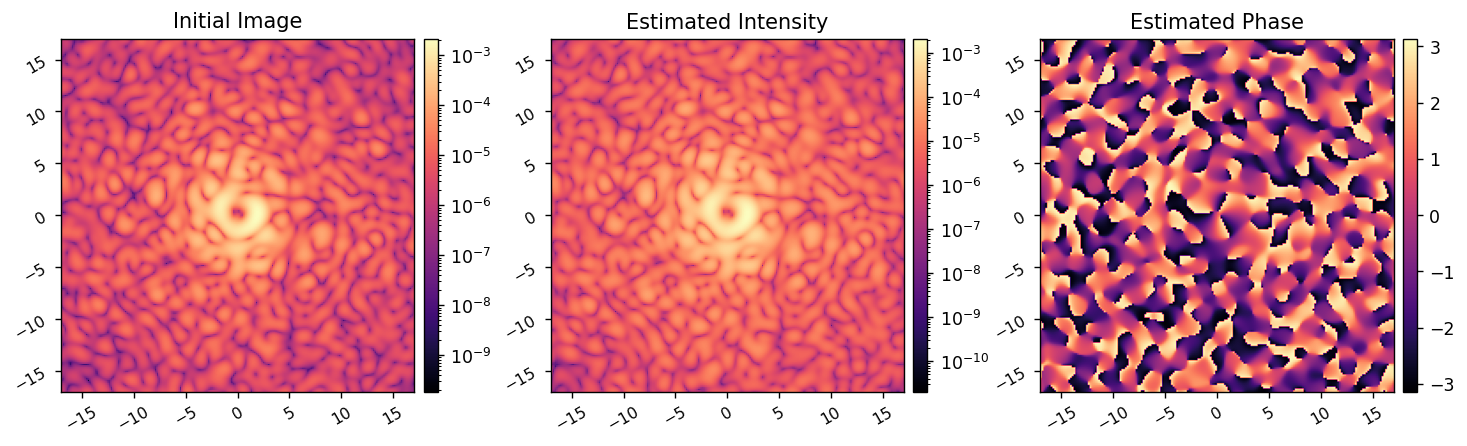

In [10]:
E_est = est_fun(model, **est_params)
imshow3(im, xp.abs(E_est)**2, xp.angle(E_est), 
        'Initial Image', 'Estimated Intensity', 'Estimated Phase',
        lognorm1=True, lognorm2=True, pxscl=model.psf_pixelscale_lamD)


In [11]:
calib_modes = lina.utils.create_hadamard_modes(model.dm_mask)
calib_amp = 2e-9

In [12]:
reload(lina.efc)
est_params.update({'plot':False})
jac = lina.efc.calibrate(model, 
                         calib_modes, calib_amp,
                         control_mask, 
                         scc_fun=est_fun, scc_params=est_params,
                         )

Calculating Jacobian: 


	Calculated response for mode 1024/1024. Elapsed time=515.080 sec.
Jacobian built in 515.080 sec


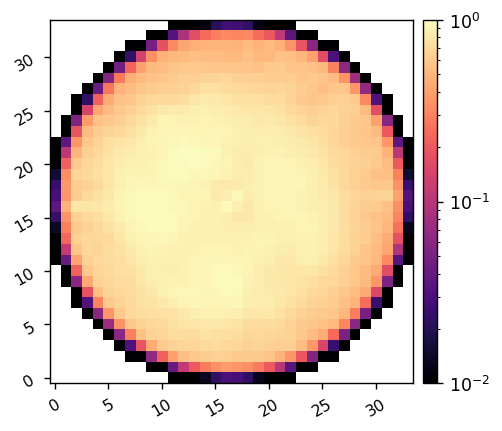

In [14]:
reload(lina.utils)
# response = lina.utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)).get(), model.dm_mask)

responses = jac[::2] + 1j*jac[1::2]
dm_response = xp.sqrt(xp.mean(xp.abs(responses.dot(xp.array(calib_modes)))**2, axis=0)).reshape(model.Nact, model.Nact)
dm_response /= xp.max(dm_response)
imshow1(dm_response, lognorm=True, vmin=1e-2)

In [35]:
control_matrix = lina.utils.beta_reg(jac, -2)

In [19]:
model.reset_dm()

images = xp.array([im])
efields = xp.array([E_est])
commands = xp.array([model.get_dm()])

Beginning closed-loop EFC.
	Running iteration 41/45.
Using estimate_coherent_mod to estimate electric field


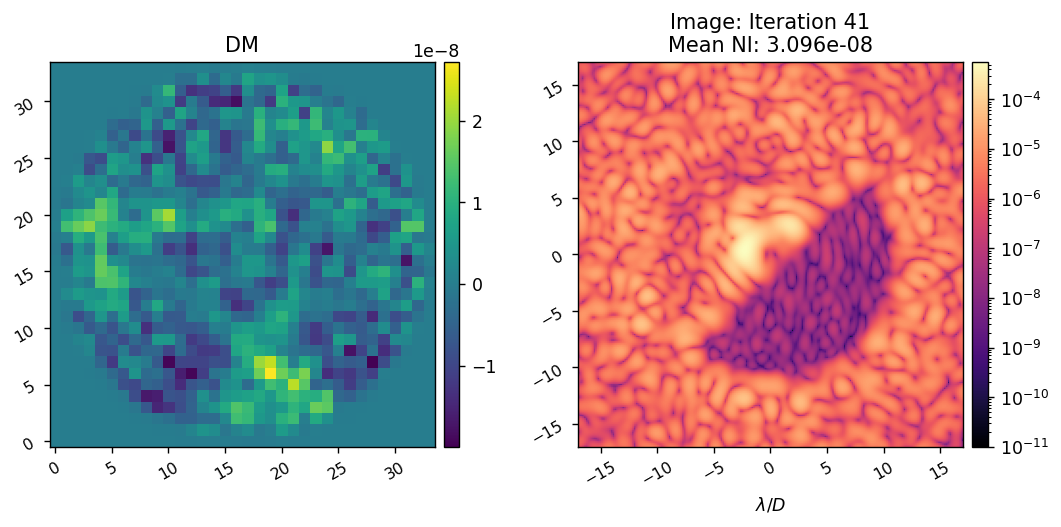

	Running iteration 42/45.
Using estimate_coherent_mod to estimate electric field


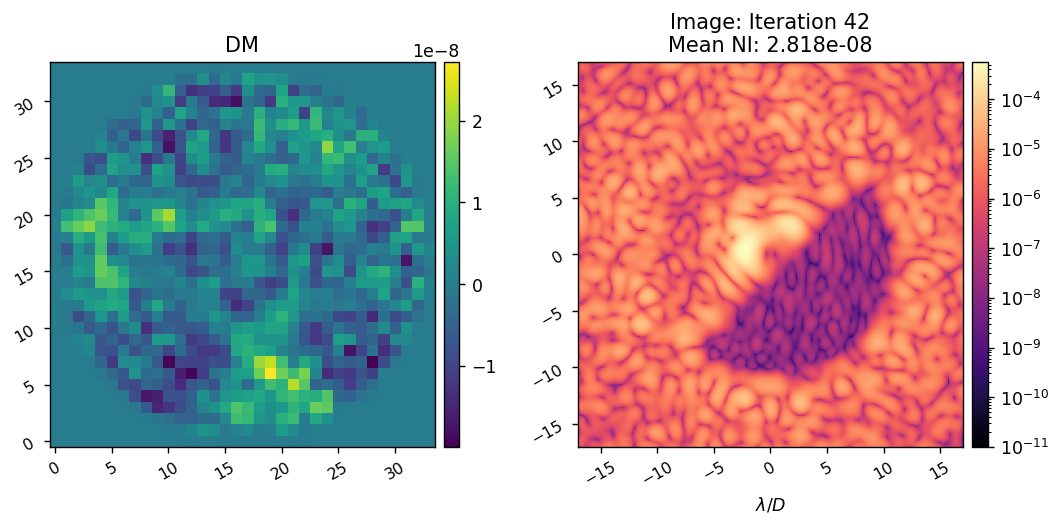

	Running iteration 43/45.
Using estimate_coherent_mod to estimate electric field


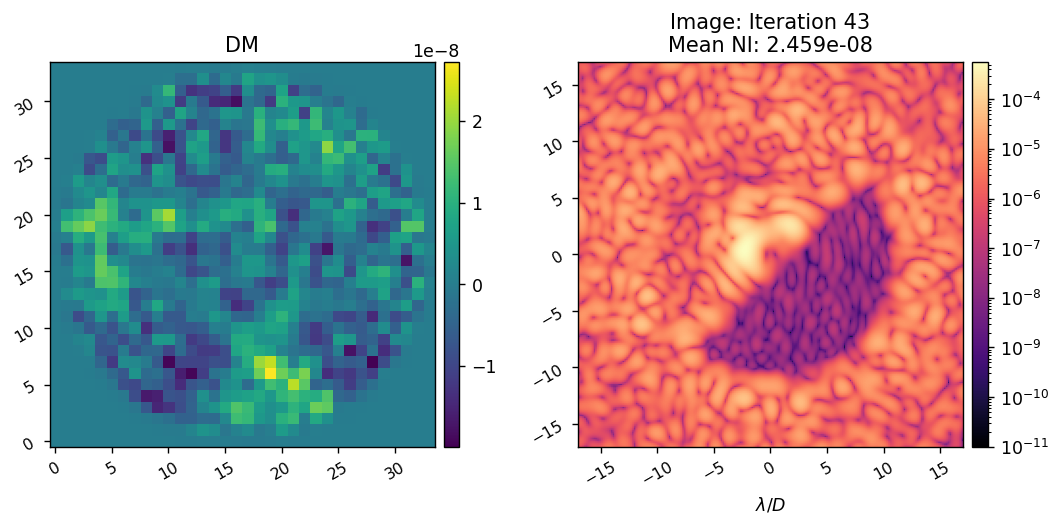

	Running iteration 44/45.
Using estimate_coherent_mod to estimate electric field


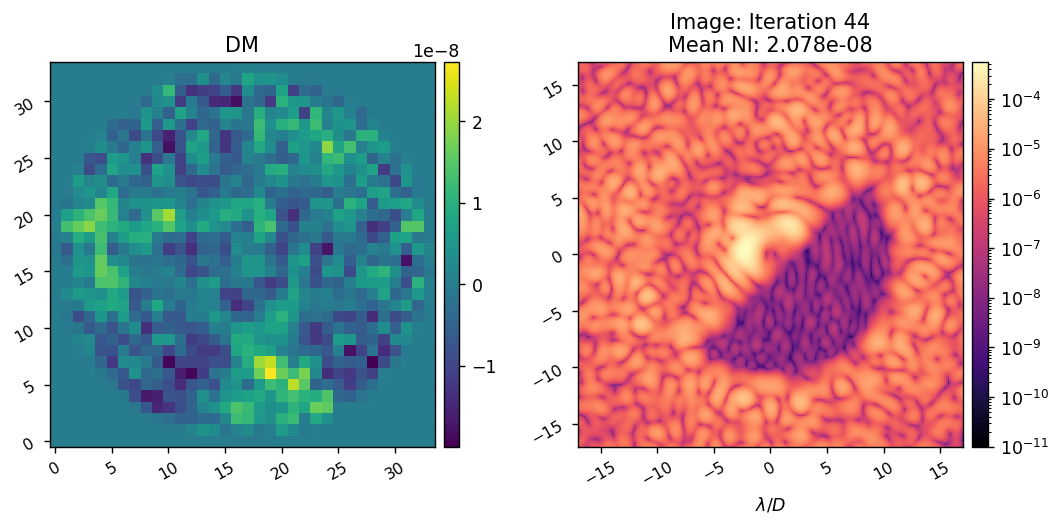

	Running iteration 45/45.
Using estimate_coherent_mod to estimate electric field


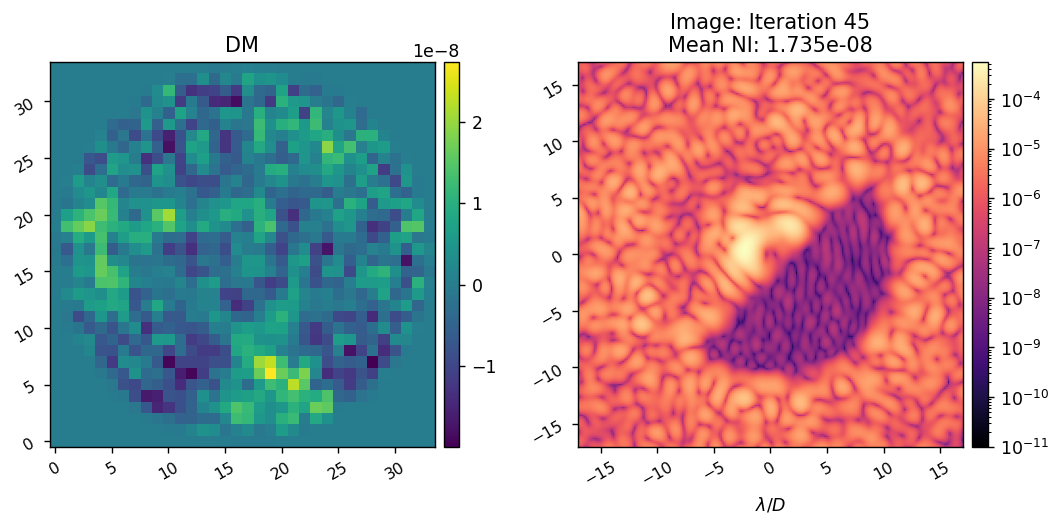

EFC completed in 4.675 sec.


In [36]:
reload(lina.efc)

images, efields, commands = lina.efc.run(model, 
                                         calib_modes,
                                        control_matrix,
                                        control_mask, 
                                        est_fun=est_fun, est_params=est_params,
                                        loop_gain=0.1, 
                                        leakage=0.0,
                                        iterations=5, 
                                        plot_all=True, 
                                        plot_radial_contrast=False,
                                        old_images=images,
                                        old_fields=efields,
                                        old_commands=commands,
                                        )